# Experiment 3: Qwn-VL Max (China) vs. GPT4 (US)

In [100]:
# turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [101]:
# imports
import pandas as pd
import numpy as np
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# load the data
tags_df = pd.read_csv('../data/experiment_3_LLM_image_captioning/tags.csv')
tags_df.head(5)

,Model,Category,Image,Chinese,Chinese (trans.),English
0,Qwen-VL,Animal,0,马，草，田野，吃草,"horse, grass, field, grazing","horse, grass, field, eat, nature"
1,Qwen-VL,Animal,1,"horse, beach, sunset, rocks","horse, beach, sunset, rocks","horse, beach, sunset"
2,Qwen-VL,Animal,2,"白色天鹅, 湖, 反射, 天空, 白云","white swan, lake, reflection, sky, white clouds","swan, water, reflection, lake, nature, animal"
3,Qwen-VL,Animal,3,"袋鼠, 跳跃, 水, 草地, 自然环境","kangaroo, jumping, water, meadow, natural envi...","kangaroo, jumping, water, grass"
4,Qwen-VL,Animal,4,"狐狸, 森林, 秋天, 自然, 动物, 生物, 红色, 尾巴, 耳朵, 眼睛, 鼻子, 脚,...","fox, forest, autumn, nature, animal, creature,...","fox, forest, autumn"


In [ ]:
# for tokenizing
nltk.download('punkt')
nltk.download('stopwords')

# function to process text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [103]:
# get a list of models ['Qwen-VL', 'GPT4'] 
models = list(tags_df['Model'].unique())
categories = list(tags_df['Category'].unique())

english_out = {}
chinese_out = {}

for model in models:
    for category in categories:
        
        # slice
        tmp_df = tags_df[(tags_df['Model']==model) & (tags_df['Category']==category)]
        
        # gather English and Chinese captions
        english_captions = [i.replace(",", "") for i in list(tmp_df['English'])]
        chinese_captions = [i.replace(",", "") for i in list(tmp_df['Chinese (trans.)'])]
        
        english_captions = [preprocess_text(i) for i in english_captions]
        chinese_captions = [preprocess_text(i) for i in chinese_captions]
        
        english_out[(model, category)] = english_captions
        chinese_out[(model, category)] = chinese_captions

## 1. Caption Length

### 1.1 Average by model, language, category

In [104]:
# build a DataFrame for the average values for each model, language, category
out = []

for category in categories:

    qwen_eng = english_out[('Qwen-VL', category)]
    qwen_eng_length = np.average([len(i) for i in qwen_eng])
    out.append([f'Qwen-VL ENG', category, qwen_eng_length])
    
    gpt_eng =  english_out[('GPT4', category)]
    gpt_eng_length = np.average([len(i) for i in gpt_eng])
    out.append([f'GPT4 ENG', category, gpt_eng_length])
    
    qwen_ch = chinese_out[('Qwen-VL', category)]
    qwen_ch_length = np.average([len(i) for i in qwen_ch])
    out.append([f'Qwen-VL CH', category, qwen_ch_length])

    gpt_ch =  chinese_out[('GPT4', category)]
    gpt_ch_length = np.average([len(i) for i in gpt_ch])
    out.append([f'GPT4 CH', category, gpt_ch_length])

length_df = pd.DataFrame(out, columns=['model, language', 'category', 'average caption length'])

In [145]:
length_df

,"model, language",category,average caption length
0,Qwen-VL ENG,Animal,4.5
1,GPT4 ENG,Animal,16.7
2,Qwen-VL CH,Animal,8.5
3,GPT4 CH,Animal,13.6
4,Qwen-VL ENG,Object,8.8
5,GPT4 ENG,Object,16.1
6,Qwen-VL CH,Object,13.7
7,GPT4 CH,Object,15.0
8,Qwen-VL ENG,People,6.4
9,GPT4 ENG,People,21.0


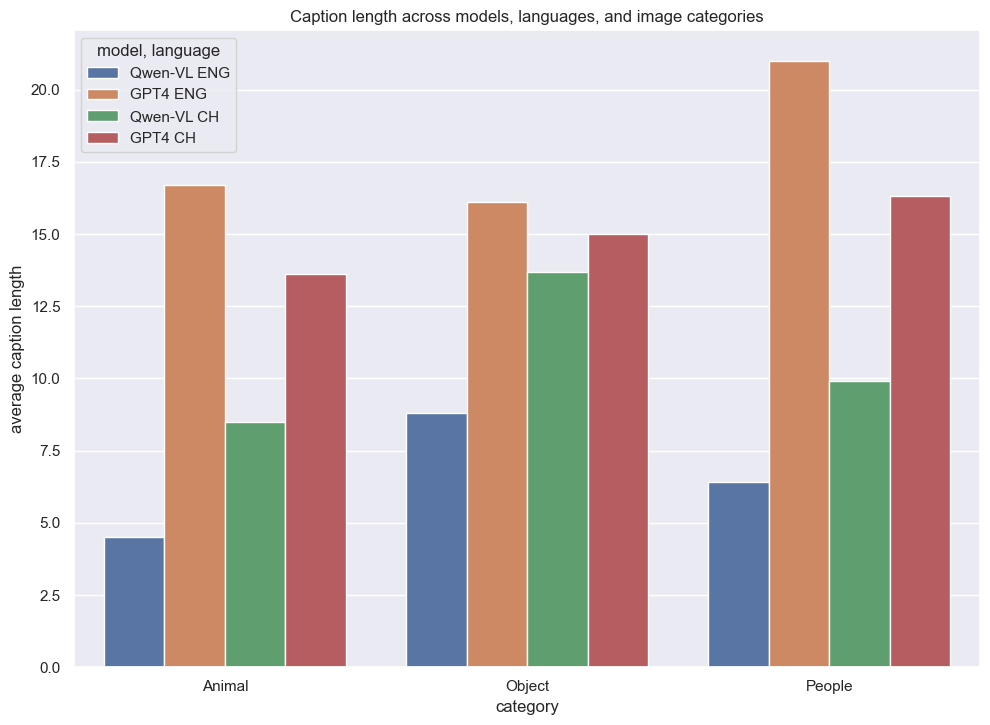

In [105]:
# display the results
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=length_df, x='category', y='average caption length', hue='model, language')

plt.title('Caption length across models, languages, and image categories')
plt.show()

### 1.2 Caption length distribution by model, language

In [106]:
# prepare models, caption lengths
x = []
y = []

# collect data
for model in models: 
    eng = []
    ch = []
    
    for category in categories:
        eng += english_out[(model, category)]
        ch += chinese_out[(model, category)]
    
    x.append((model, 'ENG'))
    y.append([len(i) for i in eng])
    x.append((model, 'CH'))
    y.append([len(i) for i in ch])

In [107]:
# calculate the shortest and longest caption for histogram bins
minimum = min([min(i) for i in y])
maximum = max([max(i) for i in y])

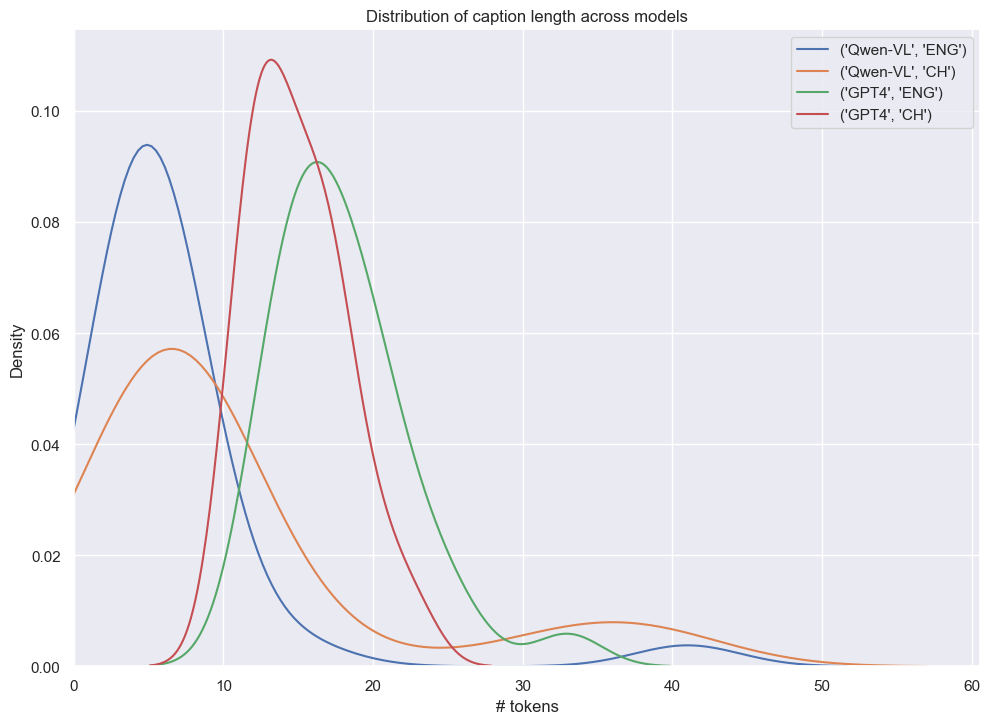

In [108]:
# display the results
for label, data in zip(x, y): 
    sns.distplot(data, hist=False, rug=False, label=label)
    
plt.title('Distribution of caption length across models')
plt.legend()
plt.xlim(0)
plt.xlabel('# tokens')
plt.show()

### 1.3 Caption length by category

In [127]:
# category, caption lengths
x = []
y = []

# collect data
for category in categories:
    eng = []
    ch = []
    
    for model in models:
        eng += english_out[(model, category)]
        ch += chinese_out[(model, category)]
    
    x.append(category)
    y.append([len(i) for i in eng] + [len(i) for i in ch])

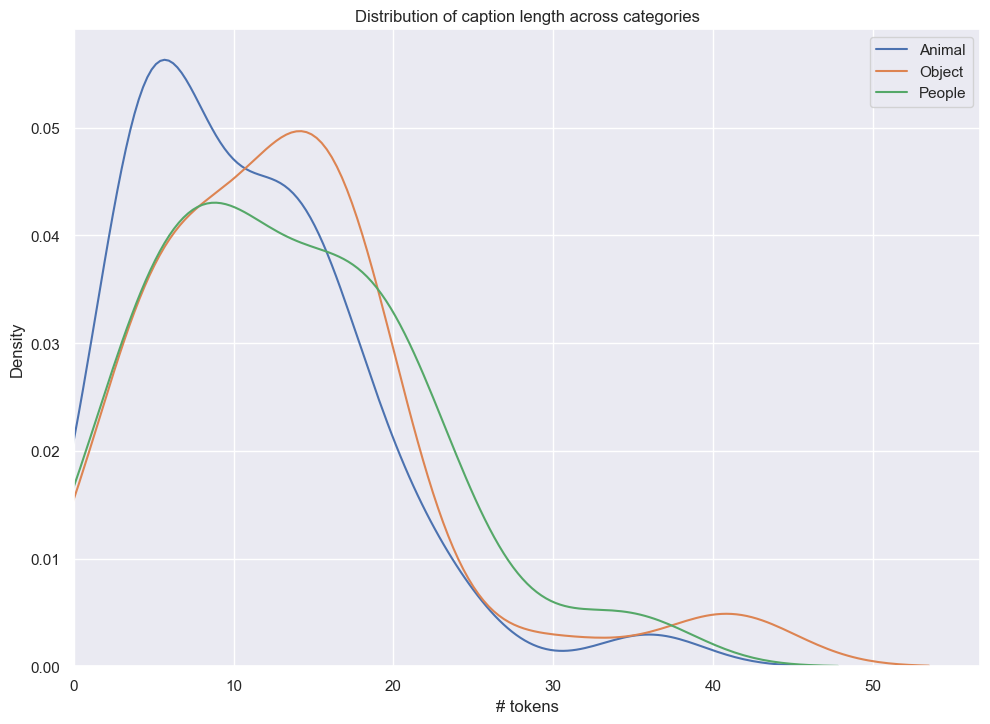

In [128]:
# display the results
for label, data in zip(x, y): 
    sns.distplot(data, hist=False, rug=False, label=label)
    
plt.title('Distribution of caption length across categories')
plt.legend()
plt.xlim(0)
plt.xlabel('# tokens')
plt.show()

## 2. Nouns, Verbs, Adjectives

In [ ]:
# for POS tagging
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

### 2.1 POS tag distributions across model, language

In [133]:
# model, captions
x = []
y = []

# collect data
for model in models: 
    eng = []
    ch = []
    
    for category in categories:
        # 'flatten' all captions together
        eng += [i for j in english_out[(model, category)] for i in j]
        ch += [i for j in chinese_out[(model, category)] for i in j]
    
    x.append((model, 'ENG'))
    y.append(eng)
    x.append((model, 'CH'))
    y.append(ch)

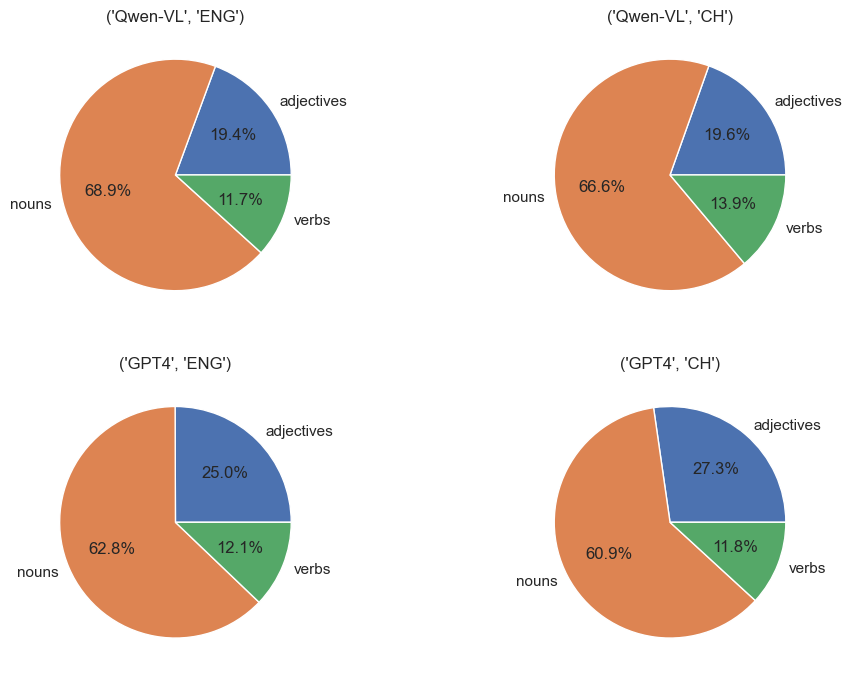

In [141]:
# display the results
fig, axs = plt.subplots(2, 2)

for i, tmp in enumerate(zip(x, y)):
    label = tmp[0]
    data = tmp[1]
    
    tagged = pos_tag(data)
    adjectives = []
    nouns = []
    verbs = []
    
    for word, tag in tagged:
        if tag.startswith('JJ'):
            adjectives.append(word)
        elif tag.startswith('NN'):
            nouns.append(word)
        elif tag.startswith('VB'):
            verbs.append(word)
    
    counts = [len(adjectives), len(nouns), len(verbs)]
    axs[i//2, i%2].pie(counts, labels=["adjectives", "nouns", "verbs"], autopct='%1.1f%%')
    axs[i//2, i%2].set_title(label)
    

In [142]:
# category, captions
x = []
y = []

# collect data
for category in categories:
    eng = []
    ch = []
    
    for model in models: 
        # 'flatten' all captions together
        eng += [i for j in english_out[(model, category)] for i in j]
        ch += [i for j in chinese_out[(model, category)] for i in j]
    x.append(category)
    y.append(eng+ch)    

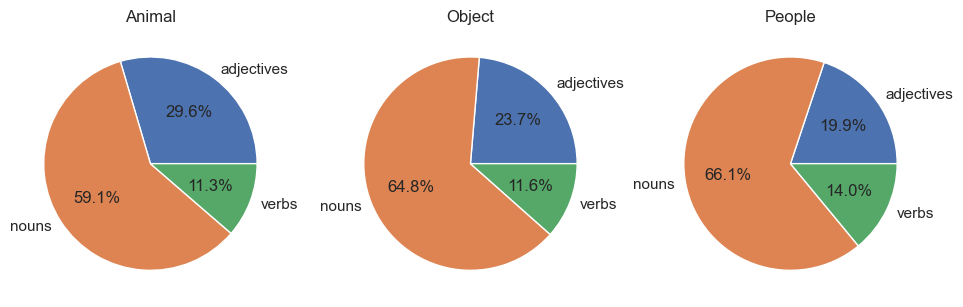

In [144]:
# display the results
fig, axs = plt.subplots(1, 3)

for i, tmp in enumerate(zip(x, y)):
    label = tmp[0]
    data = tmp[1]
    
    tagged = pos_tag(data)
    adjectives = []
    nouns = []
    verbs = []
    
    for word, tag in tagged:
        if tag.startswith('JJ'):
            adjectives.append(word)
        elif tag.startswith('NN'):
            nouns.append(word)
        elif tag.startswith('VB'):
            verbs.append(word)
    
    counts = [len(adjectives), len(nouns), len(verbs)]
    axs[i].pie(counts, labels=["adjectives", "nouns", "verbs"], autopct='%1.1f%%')
    axs[i].set_title(label)
